# Getting the data ready for the Front-End

In [1]:
import pandas as pd
import os

# Load in our data
filepath = '../../Data/Warehouse/MergedData/merged_data_clean.csv'
data = pd.read_csv(filepath)

## Dropping Columns
The model primarily found the /GP rates more useful than the /60 rates, so for simplicity we will drop the /60 columns

In [2]:
# drop all columns from data that end in '/60'
data = data.drop(data.filter(regex='/60').columns, axis=1)

In [3]:
data.columns.tolist()

['TEAM',
 'PLAYER',
 'POSITION',
 'GP',
 'TOI/GP',
 'TOI',
 'IPP',
 'GOALS',
 'TOTAL ASSISTS',
 'FIRST ASSISTS',
 'SECOND ASSISTS',
 'TOTAL POINTS',
 'SHOTS',
 'IXG',
 'ICF',
 'IFF',
 'ISCF',
 'IHDCF',
 'RUSH ATTEMPTS',
 'REBOUNDS CREATED',
 'PIM',
 'TOTAL PENALTIES',
 'MINOR',
 'MAJOR',
 'MISCONDUCT',
 'PENALTIES DRAWN',
 'GIVEAWAYS',
 'TAKEAWAYS',
 'HITS',
 'HITS TAKEN',
 'SHOTS BLOCKED',
 'FACEOFFS WON',
 'FACEOFFS LOST',
 'GOALS/GP',
 'TOTAL ASSISTS/GP',
 'FIRST ASSISTS/GP',
 'SECOND ASSISTS/GP',
 'TOTAL POINTS/GP',
 'SHOTS/GP',
 'IXG/GP',
 'ICF/GP',
 'IFF/GP',
 'ISCF/GP',
 'IHDCF/GP',
 'RUSH ATTEMPTS/GP',
 'REBOUNDS CREATED/GP',
 'PIM/GP',
 'TOTAL PENALTIES/GP',
 'MINOR/GP',
 'MAJOR/GP',
 'MISCONDUCT/GP',
 'PENALTIES DRAWN/GP',
 'GIVEAWAYS/GP',
 'TAKEAWAYS/GP',
 'HITS/GP',
 'HITS TAKEN/GP',
 'SHOTS BLOCKED/GP',
 'FACEOFFS WON/GP',
 'FACEOFFS LOST/GP',
 'SH%',
 'FACEOFFS %',
 'PDO',
 'CF',
 'CA',
 'FF',
 'FA',
 'SF',
 'SA',
 'GF',
 'GA',
 'XGF',
 'XGA',
 'SCF',
 'SCA',
 'HDCF',
 'H

In [4]:
# Load in the predictions

# Load in our data
defence_filepath = '../../Data/Warehouse/Predictions/defence_predictions.csv'
wingers_filepath = '../../Data/Warehouse/Predictions/wingers_predictions.csv'
centers_filepath = '../../Data/Warehouse/Predictions/centers_predictions.csv'

defence_predictions = pd.read_csv(defence_filepath)
wingers_predictions = pd.read_csv(wingers_filepath)
centers_predictions = pd.read_csv(centers_filepath)
print(defence_predictions.head())
print(wingers_predictions.head())
print(centers_predictions.head())

   Unnamed: 0           PLAYER   SEASON       PRED_AAV  PRED_SALARY_PERCENTAGE
0           4   alex goligoski  2007-08  $1,416,714.00                0.028165
1           6  alexander edler  2007-08  $1,164,787.00                0.023157
2          11   alexei zhitnik  2007-08  $2,674,326.00                0.053168
3          12    andreas lilja  2007-08  $1,290,424.00                0.025655
4          13    andrei markov  2007-08  $5,072,527.00                0.100845
   Unnamed: 0         PLAYER   SEASON       PRED_AAV  PRED_SALARY_PERCENTAGE
0           0    adam burish  2007-08    $631,369.00                0.012552
1           1      adam hall  2007-08    $667,488.00                0.013270
2           2    ales hemsky  2007-08  $3,904,882.00                0.077632
3           3   ales kotalik  2007-08  $2,338,045.00                0.046482
4           5  alex ovechkin  2007-08  $1,862,067.00                0.037019
   Unnamed: 0            PLAYER   SEASON       PRED_AAV  \
0    

In [5]:
# Join predictions to data. Join data on index and predictions on 'Unnamed: 0'
defence_merged = data.merge(defence_predictions, left_index=True, right_on='Unnamed: 0')
wingers_merged = data.merge(wingers_predictions, left_index=True, right_on='Unnamed: 0')
centers_merged = data.merge(centers_predictions, left_index=True, right_on='Unnamed: 0')

# Drop cols
drop_cols = ['Unnamed: 0', 'PLAYER_y', 'SEASON_y',]

defence_merged = defence_merged.drop(drop_cols, axis=1)
wingers_merged = wingers_merged.drop(drop_cols, axis=1)
centers_merged = centers_merged.drop(drop_cols, axis=1)

# Concatenate the dataframes
final_data = pd.concat([defence_merged, wingers_merged, centers_merged])

# Change column 'PLAYER_x' to 'PLAYER' and 'SEASON_x' to 'SEASON'
final_data = final_data.rename(columns={'PLAYER_x': 'PLAYER', 'SEASON_x': 'SEASON'})

In [6]:
final_data = final_data.sort_values(by=['SEASON', 'PLAYER']).reset_index(drop=True)
final_data.head(-10)[['PLAYER', 'SEASON', 'TEAM', 'PRED_SALARY_PERCENTAGE']]

,PLAYER,SEASON,TEAM,PRED_SALARY_PERCENTAGE
0,adam burish,2007-08,chi,0.012552
1,adam hall,2007-08,pit,0.013270
2,ales hemsky,2007-08,edm,0.077632
3,ales kotalik,2007-08,buf,0.046482
4,alex goligoski,2007-08,pit,0.028165
...,...,...,...,...
12134,wyatt kaiser,2023-24,chi,0.023945
12135,yakov trenin,2023-24,"col, nsh",0.025554
12136,yanni gourde,2023-24,sea,0.050825
12137,yegor chinakhov,2023-24,cbj,0.042898


In [7]:
# Create percentage of salary column
final_data['PRED/ACTUAL'] = final_data['PRED_SALARY_PERCENTAGE'] / final_data['SALARY CAP PERCENTAGE']


In [8]:
final_data['POSITION'].unique()

# Change the position column so that 'r' is 'Right Wing', 'l' is 'Left Wing', 'c' is 'Center', 'd' is 'Defence', 'c, l' is 'Center, Left Wing', 'c, r' is 'Center, Right Wing', 'l, r' is 'Left Wing, Right Wing'
final_data['POSITION'] = final_data['POSITION'].replace({'r': 'Right Wing', 'l': 'Left Wing', 'c': 'Center', 'd': 'Defence', 'c, l': 'Center, Left Wing', 'c, r': 'Center, Right Wing', 'l, r': 'Left Wing, Right Wing', 'd, l': 'Defence, Left Wing', 'd, r': 'Defence, Right Wing', 'd, c': 'Defence, Center'}) 

final_data['POSITION'].unique()

array(['Right Wing', 'Defence', 'Left Wing', 'Center, Left Wing',
       'Center', 'Left Wing, Right Wing', 'Center, Right Wing',
       'Defence, Left Wing'], dtype=object)

In [9]:
final_data['TEAM'].unique()

array(['chi', 'pit', 'edm', 'buf', 'wsh', 'van', 'nsh', 'tor', 'atl',
       'det', 'mtl', 'ott', 'bos', 'ana', 'car, chi', 'n.j', 'nyi',
       'ana, stl', 'l.a', 'dal', 'stl', 'chi, phi', 'min', 't.b',
       'dal, t.b', 'det, l.a', 'nyr', 'phi', 'fla', 'buf, s.j',
       'n.j, stl', 'nyr, stl', 's.j', 'atl, pit', 'cgy', 'cbj, edm',
       'phx', 'col', 'car', 'cbj', 'min, tor', 'pit, tor',
       'cgy, chi, phi', 'car, ott', 'col, fla', 'ana, nyi', 'van, wsh',
       'cbj, wsh', 'ana, bos', 'dal, min', 'buf, edm', 'stl, tor',
       'cbj, ott', 'dal, stl', 'nyi, pit', 'ana, dal', 'nyi, ott',
       'cbj, t.b', 'ana, pit', 'min, nyr', 'phi, phx', 'dal, pit',
       'nyr, phx', 'buf, tor', 'dal, mtl', 'ana, atl', 'car, edm',
       'mtl, phi', 'ana, chi', 'atl, cbj', 'car, t.b', 'car, l.a',
       'col, van', 'atl, mtl', 'cgy, phx', 'ana, van', 'fla, nsh',
       'fla, t.b', 'edm, l.a', 't.b, van', 'fla, phi, t.b', 'ana, s.j',
       'cgy, edm', 'ana, car', 'cgy, nyr', 'car, van', 'an

In [10]:
team_mapping = {
    'ana': 'Anaheim Ducks',
    'ari': 'Arizona Coyotes',
    'atl': 'Atlanta Thrashers',  
    'bos': 'Boston Bruins',
    'buf': 'Buffalo Sabres',
    'cgy': 'Calgary Flames',
    'car': 'Carolina Hurricanes',
    'cbj': 'Columbus Blue Jackets',
    'chi': 'Chicago Blackhawks',
    'col': 'Colorado Avalanche',
    'dal': 'Dallas Stars',
    'det': 'Detroit Red Wings',
    'edm': 'Edmonton Oilers',
    'fla': 'Florida Panthers',
    'l.a': 'Los Angeles Kings',
    'min': 'Minnesota Wild',
    'mtl': 'Montreal Canadiens',
    'n.j': 'New Jersey Devils',
    'nsh': 'Nashville Predators',
    'nyi': 'New York Islanders',
    'nyr': 'New York Rangers',
    'ott': 'Ottawa Senators',
    'phi': 'Philadelphia Flyers',
    'phx': 'Phoenix Coyotes',  
    'pit': 'Pittsburgh Penguins',
    's.j': 'San Jose Sharks',
    'stl': 'St. Louis Blues',
    't.b': 'Tampa Bay Lightning',
    'tor': 'Toronto Maple Leafs',
    'van': 'Vancouver Canucks',
    'vgk': 'Vegas Golden Knights',
    'wpg': 'Winnipeg Jets',  
    'wsh': 'Washington Capitals',
    'sea': 'Seattle Kraken',
}


In [11]:
# Function to unabbreviate team names
def unabbreviate_teams(team_abbr):
    # Split the string by comma to account for multiple teams
    teams = team_abbr.split(', ')
    # Map each abbreviation to its full name using the team_mapping
    full_names = [team_mapping.get(team.strip(), "Unknown") for team in teams]
    # Join the full names back into a string separated by commas
    return ', '.join(full_names)

In [12]:
final_data['TEAM_FULL_NAMES'] = final_data['TEAM'].apply(unabbreviate_teams)

In [13]:
# Convert all NaN values to 0

final_data = final_data.fillna(0)

In [14]:
# Save the data
outpath_dir = '../../Data/Warehouse/FrontEnd/'
outpath_file = 'front_end_data.csv'

if not os.path.exists(outpath_dir):
    os.makedirs(outpath_dir)

final_data.to_csv(outpath_dir + outpath_file, index=False)

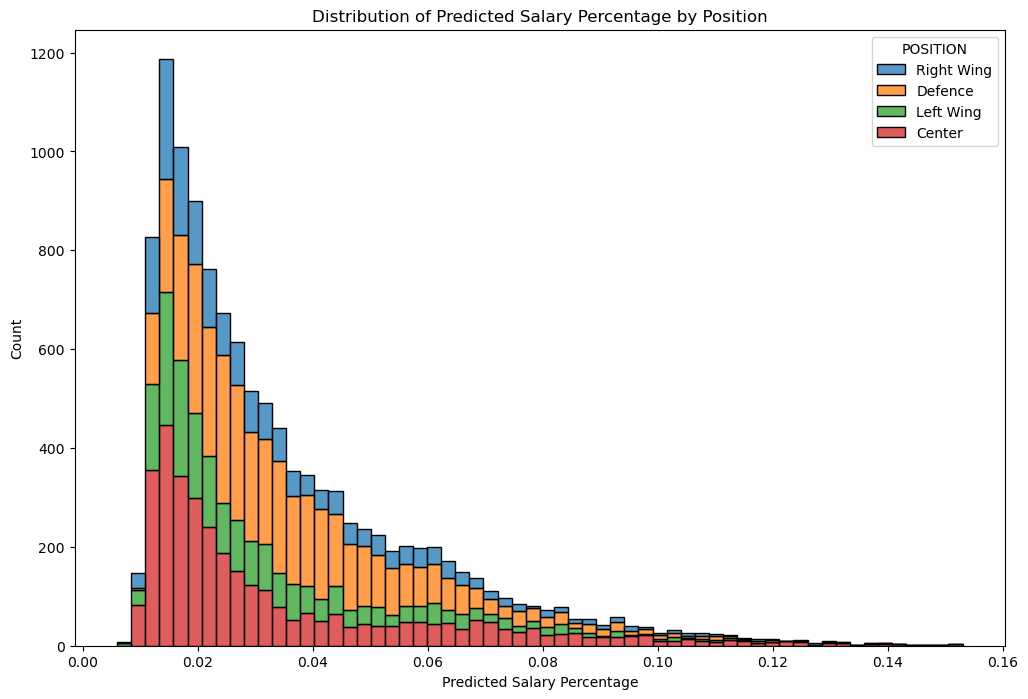

In [17]:
# Select only rows where 'POSITION' is 'Defence', 'Left Wing', 'Right Wing', or 'Center'
final_data = final_data[final_data['POSITION'].isin(['Defence', 'Left Wing', 'Right Wing', 'Center'])]

# Plot the distribution of the ''PRED_SALARY_PERCENTAGE'' column for each position
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.histplot(data=final_data, x='PRED_SALARY_PERCENTAGE', hue='POSITION', multiple='stack')
plt.title('Distribution of Predicted Salary Percentage by Position')
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Count')
plt.show()

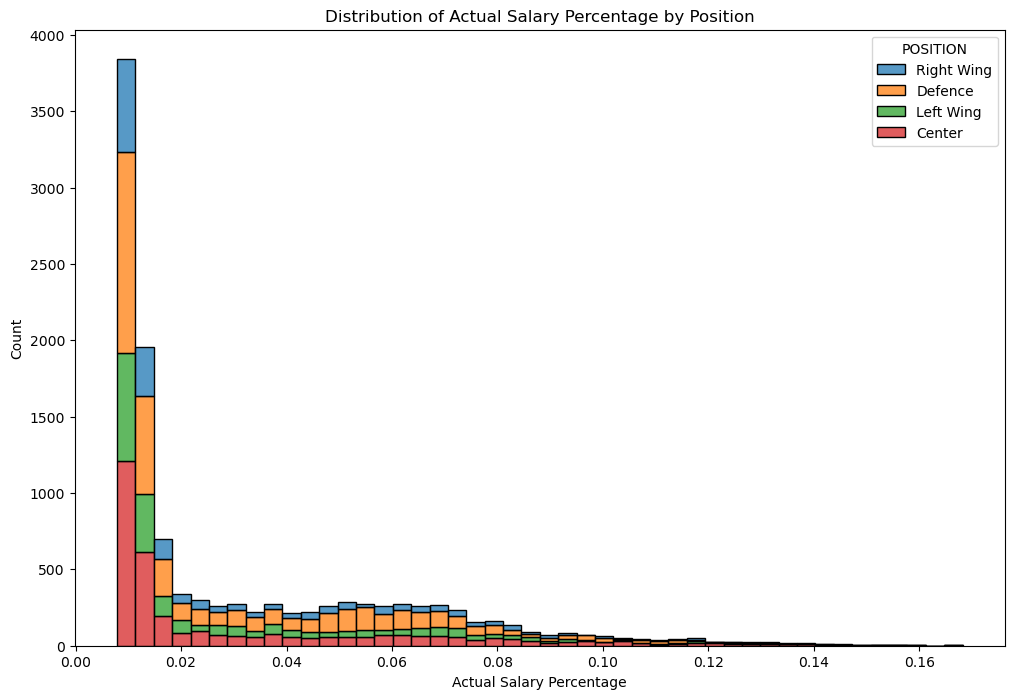

In [18]:
# Plot the distribution of the 'SALARY CAP PERCENTAGE' column for each position
plt.figure(figsize=(12, 8))
sns.histplot(data=final_data, x='SALARY CAP PERCENTAGE', hue='POSITION', multiple='stack')
plt.title('Distribution of Actual Salary Percentage by Position')
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Count')
plt.show()